In [1]:
import xdem
import rioxarray as rix
import xarray as xr
import numpy as np
import glob
import os
from datetime import datetime
import matplotlib.pyplot as plt
import altair as alt
from pathlib import Path
from rasterio.enums import Resampling
import pandas as pd
import geopandas as gpd
import geoutils as gu
from pysheds.grid import Grid

import matplotlib.cm
import altair as alt
import copy
import seaborn as sns

In [2]:
# !gdal_translate -tr 10 10 \
#     "/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/whole_mountain/dems/1947_09_14.tif" \
#     "/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/whole_mountain/dems/1947_09_14_lowres.tif"

In [3]:
early_dem_fn = "/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/whole_mountain/dems/1947_09_14.tif"
late_dem_fn = "/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/whole_mountain/dems/2015_09_01.tif"

dtm_fn = '/data2/elilouis/hsfm-geomorph/data/reference_dem_highres/baker/raw_tifs/baker_2015/2015_dtm_10m.tif'
# dtm_fn = "/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/whole_mountain/dems/1947_09_14_lowres.tif"

initiation_polygons_fn = "/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/whole_mountain/erosion_initiation.shp"
gully_polygons_fn = "/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/whole_mountain/gully.shp"
wasting_polygons_fn = "/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/whole_mountain/mass_wasting.shp"
glacial_debutressing_polygons_fn = "/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/whole_mountain/debutressing.shp"


glacier_polys_fns = glob.glob("/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/**/glaciers.geojson", recursive=True)
erosion_polys_fns = glob.glob("/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/**/erosion.geojson", recursive=True)

dods_output_path = "/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/whole_mountain/dods/"

strip_time_format = "%Y_%m_%d"
reference_dem_date = "2015_09_01"
reference_dem_date = datetime.strptime(
    reference_dem_date, 
    strip_time_format
)

streamstats_watersheds_fns = glob.glob("/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/streamstats_watersheds/*.geojson")

dod_uncertainty_fn = "/home/elilouis/hsfm-geomorph/dem-analysis/mt_baker_mass_wasted/outputs/uncertainty_wholemountain.pcl"

FILTER_OUTLIERS = True
SIMPLE_FILTER = True
simple_filter_threshold = 50
INTERPOLATE = True
interpolation_max_search_distance = 50
reasonable_bounds = (580000, 5395000, 595000, 5413000)

# Prepare DDEMs

In [4]:
dem_fn_list = [early_dem_fn, late_dem_fn]
datetimes = [datetime.strptime(Path(f).stem, strip_time_format) for f in dem_fn_list]

#### Create DEMCollection and calculate DDEMs

In [5]:
demcollection = xdem.DEMCollection.from_files(
    dem_fn_list, 
    datetimes, 
    reference_dem_date, 
    None, 
    10,
    resampling = Resampling.cubic
)

In [6]:
_ = demcollection.subtract_dems_intervalwise()

#### Remove outliers and then interpolate

In [7]:
if FILTER_OUTLIERS:
    if SIMPLE_FILTER:
        for dh in demcollection.ddems:
            dh.data = np.ma.masked_where(np.abs(dh.data) > simple_filter_threshold, dh.data)
    else:
        for dh in demcollection.ddems:
            all_values_masked = dh.data.copy()
            all_values = all_values_masked.filled(np.nan)
            low = np.nanmedian(all_values) - 4*xdem.spatialstats.nmad(all_values)
            high = np.nanmedian(all_values) + 4*xdem.spatialstats.nmad(all_values)
            print(np.nanmax(dh.data))
            print(np.nanmin(dh.data))
            print(dh.interval)
            print(low)
            print(high)
            all_values_masked = np.ma.masked_greater(all_values_masked, high)
            all_values_masked = np.ma.masked_less(all_values_masked, low)
            dh.data = all_values_masked
            print(np.nanmax(dh.data))
            print(np.nanmin(dh.data))
            print()

if INTERPOLATE:
    interpolated_ddems = demcollection.interpolate_ddems(max_search_distance=interpolation_max_search_distance)
    demcollection.set_ddem_filled_data()

#### Open glacier polygons and remove glacier signals

In [8]:
from pprint import pprint

In [9]:
all_glaciers_gdf = pd.concat([gpd.read_file(f) for f in glacier_polys_fns]).to_crs(demcollection.dems[0].crs)
formatted_timestamps = [datetime.strftime(pd.to_datetime(ts), strip_time_format) for ts in demcollection.timestamps]
glaciers_gdf = all_glaciers_gdf[all_glaciers_gdf.year.isin(formatted_timestamps)]
glaciers_gdf['date'] = glaciers_gdf['year'].apply(lambda x: datetime.strptime(x, strip_time_format))

/home/elilouis/mambaforge/envs/hsfm/lib/python3.9/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [10]:
for ddem in demcollection.ddems:
    ddem
    relevant_glaciers_gdf = glaciers_gdf[glaciers_gdf['date'].isin([ddem.interval.left, ddem.interval.right])]
    relevant_glaciers_mask = gu.Vector(relevant_glaciers_gdf).create_mask(ddem).squeeze()
    ddem.data.mask = np.logical_or(ddem.data.mask, relevant_glaciers_mask)

In [11]:
import math


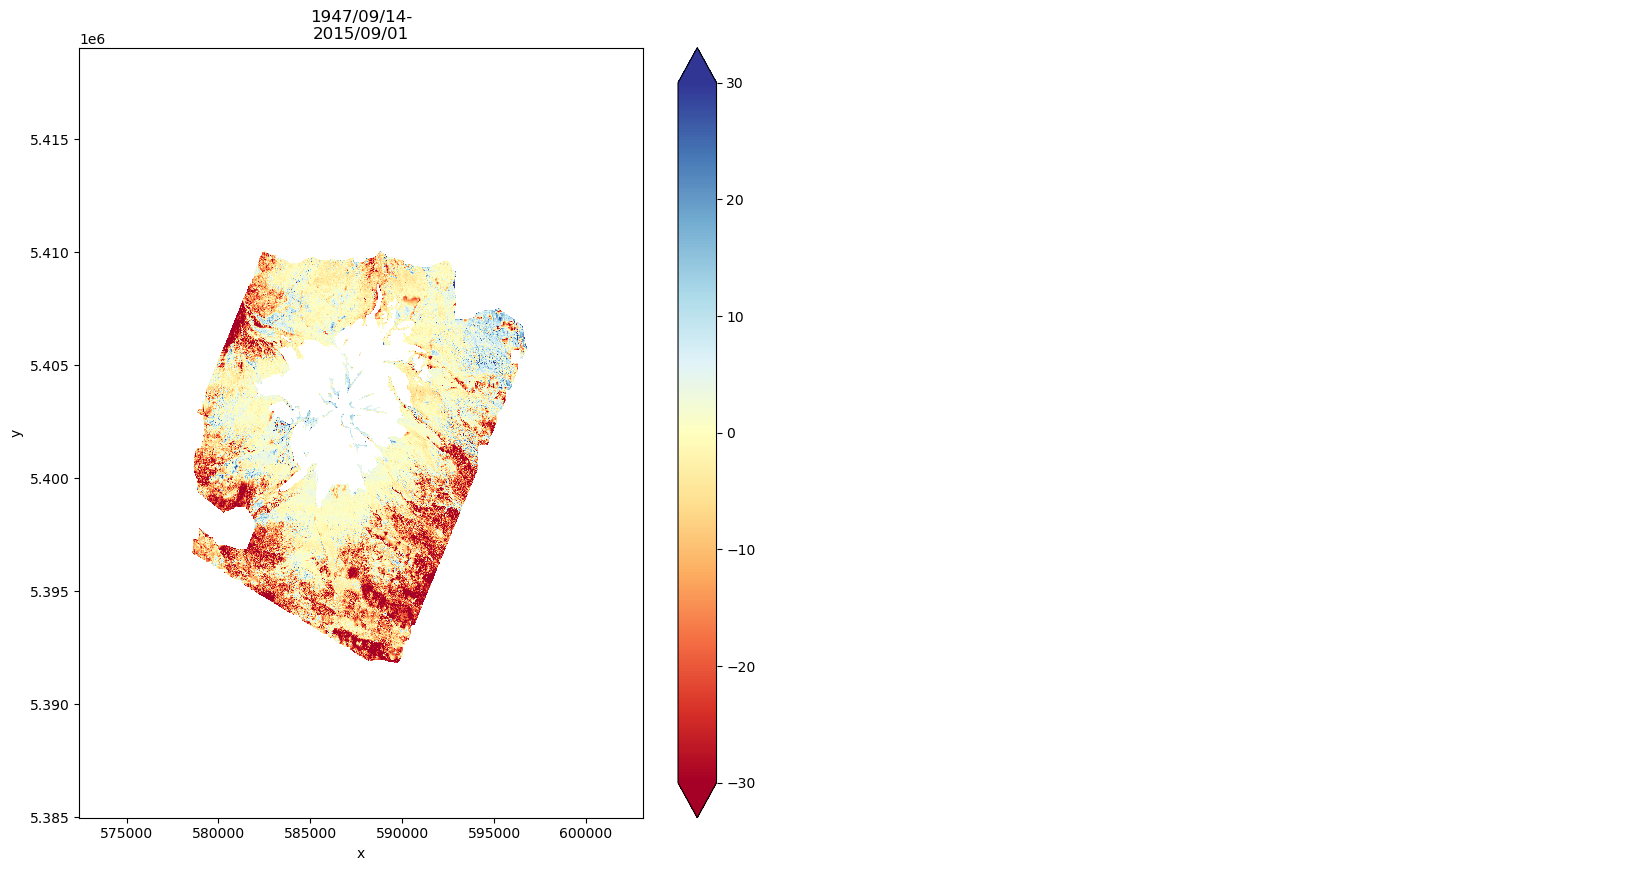

In [12]:
demcollection.plot_ddems(max_cols=2, figsize=(20,10))
plt.gca().set_aspect('equal')

# Prepare terrain attributes

#### Use xdem for some

In [13]:
dtm = xdem.DEM(dtm_fn)

In [14]:
def plot_attribute(attribute, cmap = 'Blues', label=None, vlim=None):

    add_cb = True if label is not None else False

    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(111)

    if vlim is not None:
        if isinstance(vlim, (int, float)):
            vlims = {"vmin": -vlim, "vmax": vlim}
        elif len(vlim) == 2:
            vlims = {"vmin": vlim[0], "vmax": vlim[1]}
    else:
        vlims = {}

    attribute.show(
        ax=ax,
        cmap=cmap,
        add_cb=add_cb,
        cb_title=label,
        **vlims
    )

    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

    plt.show()

In [15]:
slope = xdem.terrain.slope(dtm)
aspect = xdem.terrain.aspect(dtm)
curvature = xdem.terrain.curvature(dtm)

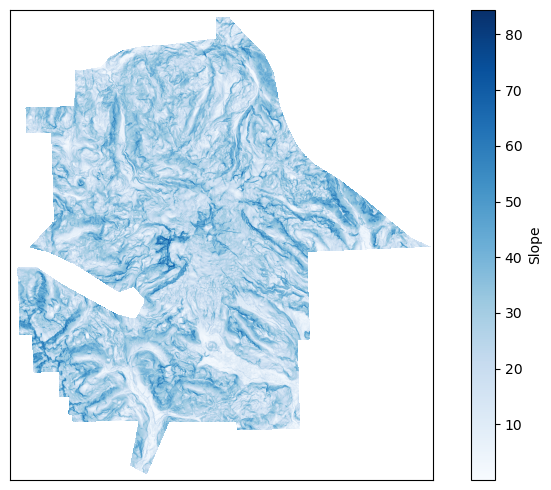

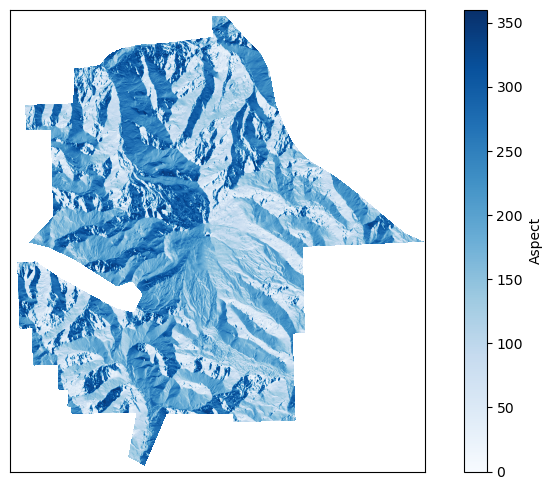

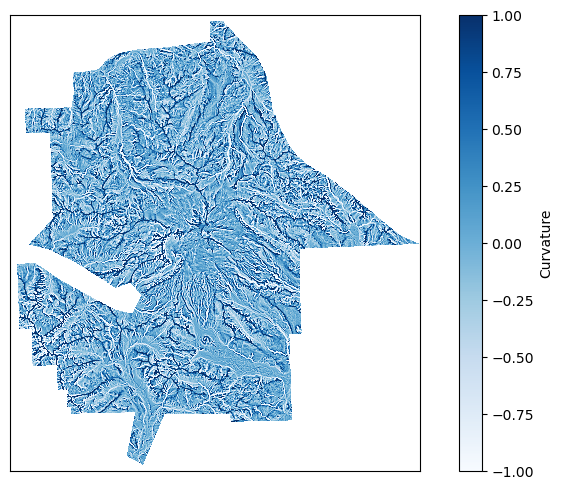

In [16]:
plot_attribute(slope, label='slope'.title())
plot_attribute(aspect, label='aspect'.title())
plot_attribute(curvature, label='curvature'.title(), vlim=1)

#### Use pysheds for drainage area

In [17]:
# grid_pysheds = Grid.from_raster(dtm_fn, 'dem')
# dem_pysheds = grid_pysheds.read_raster(dtm_fn, 'dem')

# pit_filled_dem_pysheds = grid_pysheds.fill_pits(dem_pysheds)
# flooded_dem_pysheds = grid_pysheds.fill_depressions(pit_filled_dem_pysheds)
# inflated_dem_pysheds = grid_pysheds.resolve_flats(flooded_dem_pysheds)
# fdir_pysheds = grid_pysheds.flowdir(inflated_dem_pysheds) #May need to pass in a dirmap dirmap=dirmap
# acc_pysheds = grid_pysheds.accumulation(fdir_pysheds)

In [18]:
# import tempfile
# with tempfile.NamedTemporaryFile() as tmp:
#     Grid.from_raster(acc_pysheds).to_raster(acc_pysheds, tmp.name)
#     darea = rix.open_rasterio(tmp.name)

In [19]:
darea = rix.open_rasterio('drainagearea_2015.tif')

### Adjust drainage area by pixel area

In [20]:
# darea = darea*np.abs(dtm.res[0]*dtm.res[1])

In [21]:
# darea.rio.to_raster('drainage_area.tif')

In [22]:
darea = rix.open_rasterio('drainage_area.tif')

# Create Dataset

In [23]:
# ddem = demcollection.ddems[0].to_xarray(masked=True)
# ddem.data = demcollection.ddems[0].data.filled(np.nan)

# dtm = rix.open_rasterio(dtm_fn, masked=True)

ddem = demcollection.ddems[0].to_xarray()
ddem.data = demcollection.ddems[0].data.filled(np.nan)

dtm = rix.open_rasterio(dtm_fn)

In [24]:
for k,v in {
    'dtm': dtm,
    'ddem': ddem,
    'drainage area': darea,
    'slope': slope.to_xarray(),
    'aspect': aspect.to_xarray(),
    'curvature': curvature.to_xarray()
}.items():
    print(k)
    print(v.shape)
    print(v.rio.crs)
    print(v.rio.resolution())
    print()

dtm
(1, 3408, 3066)
EPSG:32610
(10.0, -10.0)

ddem
(1, 3409, 3066)
EPSG:32610
(10.0, -10.0)

drainage area
(1, 3408, 3066)
EPSG:32610
(10.0, -10.0)

slope
(1, 3408, 3066)
EPSG:32610
(10.0, -10.0)

aspect
(1, 3408, 3066)
EPSG:32610
(10.0, -10.0)

curvature
(1, 3408, 3066)
EPSG:32610
(10.0, -10.0)



In [25]:
dataset = xr.Dataset({
    'dtm': dtm,
    'ddem': ddem.rio.reproject_match(dtm),
    'drainage area': darea,
    'slope': slope.to_xarray(),
    'aspect': aspect.to_xarray(),
    'curvature': curvature.to_xarray()
})

# Clip dataset to bounds and remove glacier signals

In [26]:
dataset = dataset.rio.clip_box(*reasonable_bounds)
dataset = dataset.rio.clip(glaciers_gdf.geometry, invert=True)

# Plot Rasters

/tmp/ipykernel_117868/513638428.py:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset[list(dataset.data_vars)[i]].values, ax = axes[1, i])
/tmp/ipykernel_117868/513638428.py:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset[list(dataset.data_vars)[i]].values, ax = axes[1, i])
/tmp

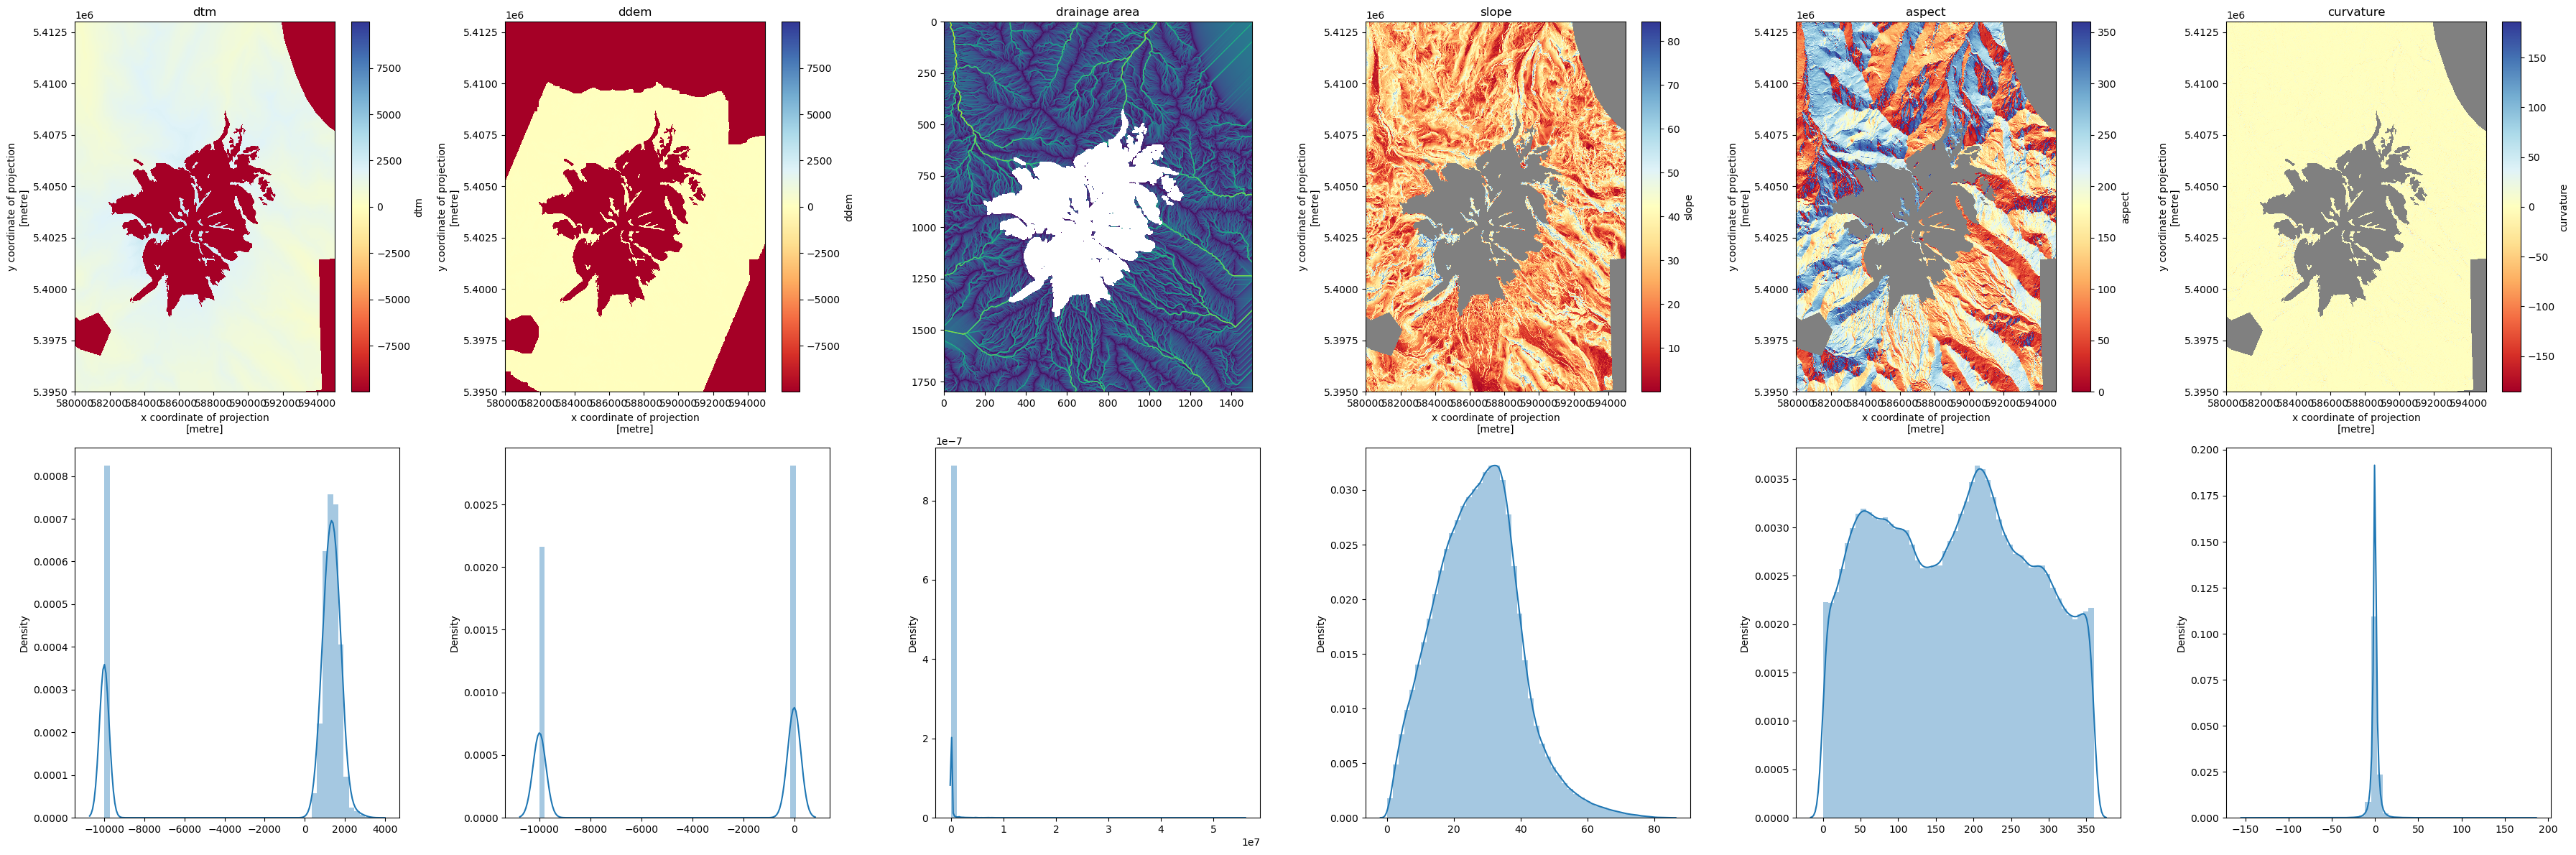

In [27]:
fig, axes = plt.subplots(2, len(dataset.data_vars), figsize=(6*len(dataset.data_vars), 6*2))

cmap = copy.copy(matplotlib.cm.RdYlBu)
_ = cmap.set_bad('grey')
from matplotlib import colors

for i in range(0, len(dataset.data_vars)):
    if list(dataset.data_vars)[i] == 'drainage area':
        axes[0, i].imshow(dataset['drainage area'].values.squeeze(), norm=colors.LogNorm())
    else:
        dataset[list(
            dataset.data_vars)[i]
        ].plot(ax = axes[0, i], cmap=cmap)
    axes[0, i].set_title(list(dataset.data_vars)[i])
    sns.distplot(dataset[list(dataset.data_vars)[i]].values, ax = axes[1, i])
    # histplot instead of distplot
    # and add the keyword args  kde=True, stat="density", linewidth=0
    # sns.histplot(dataset[list(dataset.data_vars)[i]].values.squeeze(), ax = axes[1, i], kde=True, stat="density", linewidth=0)

plt.tight_layout()
plt.show()

# Open erosion polygons

In [28]:
erosion_gdf = pd.concat([gpd.read_file(f) for f in erosion_polys_fns])

<Axes: >

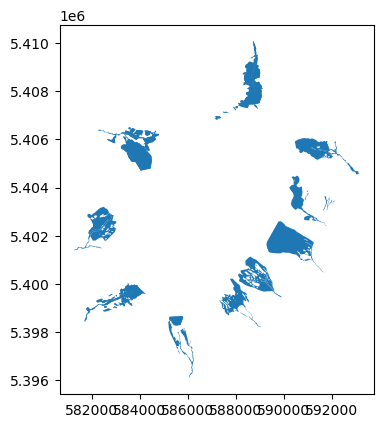

In [29]:
erosion_gdf.plot()

In [30]:
dataset

<xarray.Dataset>
Dimensions:        (band: 1, x: 1501, y: 1801)
Coordinates:
  * band           (band) int64 1
  * x              (x) float64 5.8e+05 5.8e+05 5.8e+05 ... 5.95e+05 5.95e+05
  * y              (y) float64 5.413e+06 5.413e+06 ... 5.395e+06 5.395e+06
    spatial_ref    int64 0
Data variables:
    dtm            (band, y, x) float32 510.3 508.8 ... -9.999e+03 -9.999e+03
    ddem           (band, y, x) float32 -9.999e+03 -9.999e+03 ... -9.999e+03
    drainage area  (band, y, x) float64 5e+03 100.0 1.9e+03 ... 6e+03 6.1e+03
    slope          (band, y, x) float64 25.16 27.53 29.62 32.28 ... nan nan nan
    aspect         (band, y, x) float64 33.21 21.35 21.44 30.84 ... nan nan nan
    curvature      (band, y, x) float64 -2.469 1.982 -0.4196 ... nan nan nan

# Slope-Area Analysis

## Terrain Characteristics of Hillslope and Fluvial areas

In [31]:
import numpy as np

In [32]:
darea_bins = [10**x for x in np.arange(2, 10, 0.5)]

In [33]:
darea_bins

[100.0,
 316.22776601683796,
 1000.0,
 3162.2776601683795,
 10000.0,
 31622.776601683792,
 100000.0,
 316227.7660168379,
 1000000.0,
 3162277.6601683795,
 10000000.0,
 31622776.60168379,
 100000000.0,
 316227766.01683795,
 1000000000.0,
 3162277660.1683793]

In [34]:
def get_df(ds):
    return ds.to_dataframe().reset_index().drop(columns=['band', 'spatial_ref'])
def binned_medians(df):
    binned_medians_df = pd.DataFrame(df.groupby(pd.cut(df['drainage area'], bins=darea_bins))['slope'].median()).reset_index()
    binned_medians_df['drainage area'] = binned_medians_df['drainage area'].apply(lambda interval: np.mean([interval.left, interval.right]))
    return binned_medians_df

all_data_df = get_df(dataset)
hillslope_data_df = get_df(dataset.rio.clip(erosion_gdf.query("type == 'hillslope'").geometry))
fluvial_data_df = get_df(dataset.rio.clip(erosion_gdf.query("type == 'fluvial'").geometry))

all_data_binned_df = binned_medians(all_data_df)
hillslope_data_binned_df = binned_medians(hillslope_data_df)
fluvial_data_binned_df = binned_medians(fluvial_data_df)

/tmp/ipykernel_117868/521134335.py:23: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  lgnd1.legendHandles[0]._sizes = [30]
/tmp/ipykernel_117868/521134335.py:24: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  lgnd1.legendHandles[1]._sizes = [30]
/tmp/ipykernel_117868/521134335.py:25: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  lgnd2.legendHandles[0]._sizes = [30]
/tmp/ipykernel_117868/521134335.py:26: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  lgnd2.legendHandles[1]._sizes = [30]
/tmp/ipykernel_117868/521134

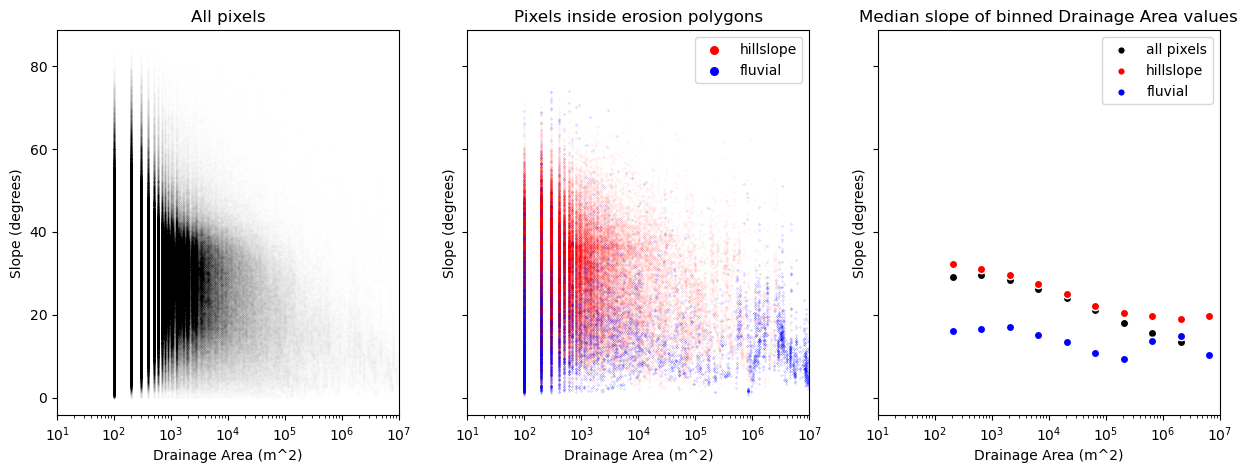

In [35]:
fig, axes = plt.subplots(1,3, figsize=(15,5), sharex=True, sharey=True)
axes[0].scatter(all_data_df['drainage area'], all_data_df['slope'], s=0.00001, color='k')
axes[1].scatter(hillslope_data_df['drainage area'], hillslope_data_df['slope'], s=0.001, color='red', label='hillslope')
axes[1].scatter(fluvial_data_df['drainage area'], fluvial_data_df['slope'], s=0.01, color='blue', label='fluvial')

axes[2].scatter(all_data_binned_df['drainage area'], all_data_binned_df['slope'], color='k', edgecolors= "white", label='all pixels')
axes[2].scatter(hillslope_data_binned_df['drainage area'], hillslope_data_binned_df['slope'], color='red', edgecolors= "white", label='hillslope')
axes[2].scatter(fluvial_data_binned_df['drainage area'], fluvial_data_binned_df['slope'], color='blue', edgecolors= "white", label='fluvial')

for ax in axes:
    ax.set_xlim(10,10e6)
    # ax.set_ylim(0,1.5)
    ax.set_xscale('log')
    ax.set_xlabel("Drainage Area (m^2)")
    ax.set_ylabel("Slope (degrees)")

axes[0].set_title("All pixels")
axes[1].set_title("Pixels inside erosion polygons")
lgnd1 = axes[1].legend(loc="upper right")
axes[2].set_title("Median slope of binned Drainage Area values")
lgnd2 = axes[2].legend(loc="upper right")

lgnd1.legendHandles[0]._sizes = [30]
lgnd1.legendHandles[1]._sizes = [30]
lgnd2.legendHandles[0]._sizes = [30]
lgnd2.legendHandles[1]._sizes = [30]
lgnd2.legendHandles[2]._sizes = [30]

plt.show()

/tmp/ipykernel_117868/2505844567.py:17: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  lgnd1.legendHandles[0]._sizes = [30]
/tmp/ipykernel_117868/2505844567.py:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  lgnd1.legendHandles[1]._sizes = [30]


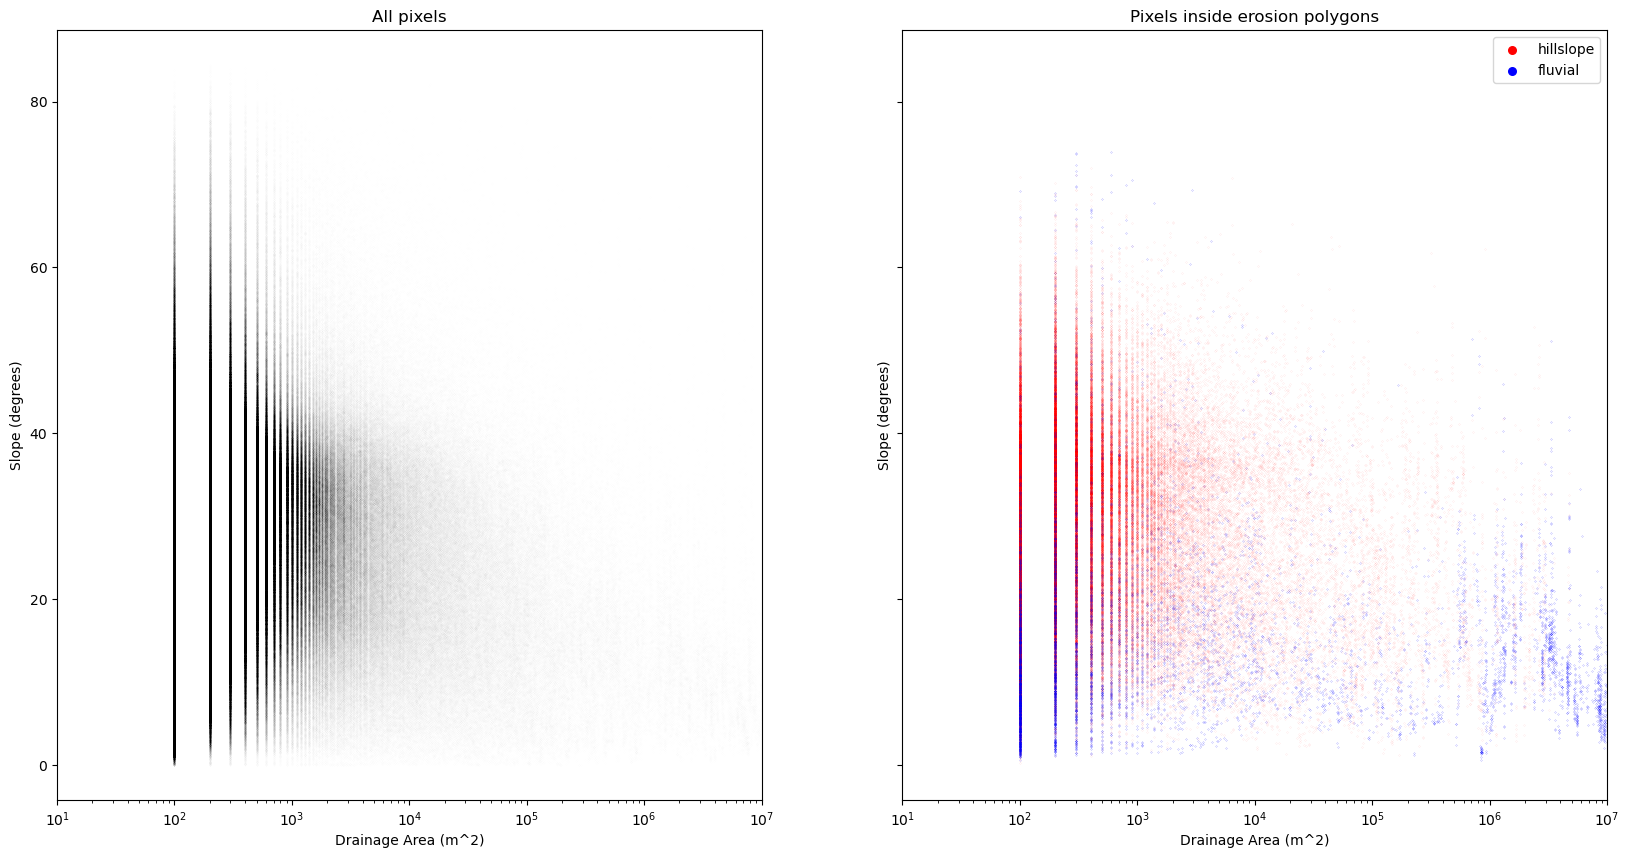

In [36]:
fig, axes = plt.subplots(1,2, figsize=(20,10), sharex=True, sharey=True)
axes[0].scatter(all_data_df['drainage area'], all_data_df['slope'], s=0.00001, color='k')
axes[1].scatter(hillslope_data_df['drainage area'], hillslope_data_df['slope'], s=0.001, color='red', label='hillslope')
axes[1].scatter(fluvial_data_df['drainage area'], fluvial_data_df['slope'], s=0.01, color='blue', label='fluvial')

for ax in axes:
    ax.set_xlim(10,10e6)
    # ax.set_ylim(0,1.5)
    ax.set_xscale('log')
    ax.set_xlabel("Drainage Area (m^2)")
    ax.set_ylabel("Slope (degrees)")

axes[0].set_title("All pixels")
axes[1].set_title("Pixels inside erosion polygons")
lgnd1 = axes[1].legend(loc="upper right")

lgnd1.legendHandles[0]._sizes = [30]
lgnd1.legendHandles[1]._sizes = [30]

plt.show()

## Terrain Characteristics of Erosion Initiation Sites

In [37]:
initiation_gdf = gpd.read_file(initiation_polygons_fn)
initiation_gdf = initiation_gdf.to_crs(dataset.rio.crs)

In [38]:
mean_results = initiation_gdf.apply(
    (lambda row: dataset.rio.clip([row['geometry']]).to_dataframe().mean()),
    axis='columns', result_type='expand'
)
initiation_gdf[mean_results.columns] = mean_results

In [39]:
initiation_gdf['type'].unique()

array(['gully', 'channel', 'rockfall'], dtype=object)

/tmp/ipykernel_117868/2302987795.py:4: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(initiation_gdf['drainage area'], initiation_gdf['slope'], color='purple', edgecolors= "white", marker='+')


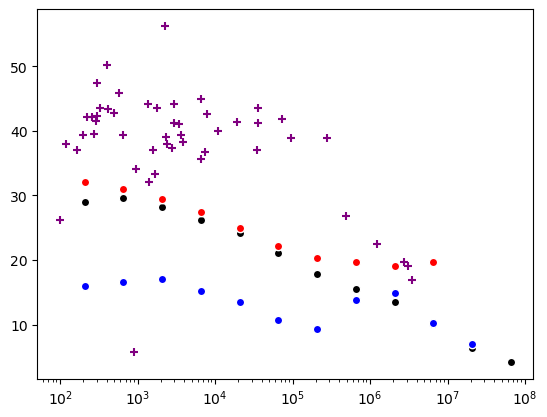

In [40]:
plt.scatter(all_data_binned_df['drainage area'], all_data_binned_df['slope'], color='k', edgecolors= "white")
plt.scatter(hillslope_data_binned_df['drainage area'], hillslope_data_binned_df['slope'], color='red', edgecolors= "white")
plt.scatter(fluvial_data_binned_df['drainage area'], fluvial_data_binned_df['slope'], color='blue', edgecolors= "white")
plt.scatter(initiation_gdf['drainage area'], initiation_gdf['slope'], color='purple', edgecolors= "white", marker='+')
plt.xscale('log')
plt.show()

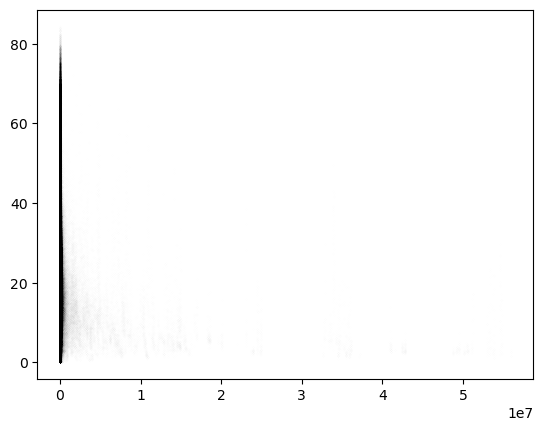

In [41]:
plt.scatter(all_data_df['drainage area'], all_data_df['slope'], s=0.00001, color='k')

/tmp/ipykernel_117868/3380489473.py:26: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('1').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(
/tmp/ipykernel_117868/3380489473.py:42: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


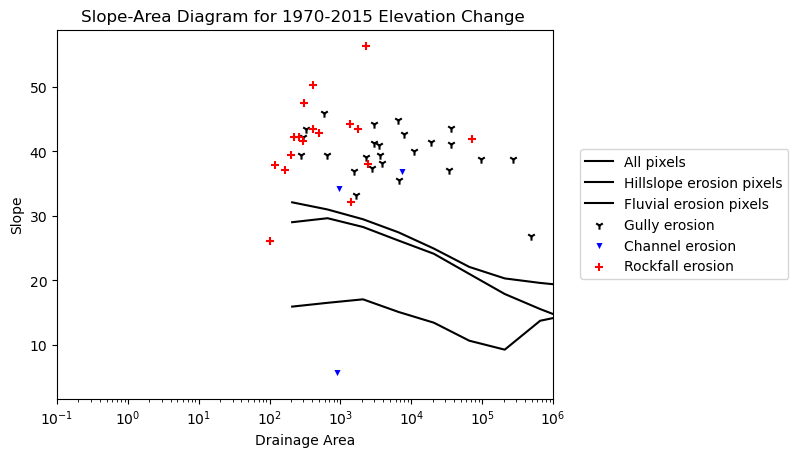

In [42]:
plt.plot(
    all_data_binned_df['drainage area'], 
    all_data_binned_df['slope'], 
    color='k', 
    # s=20, 
    # edgecolors= "white",
    label = 'All pixels'
)
plt.plot(
    hillslope_data_binned_df['drainage area'], 
    hillslope_data_binned_df['slope'], 
    color='k', 
    # s=20, 
    # edgecolors= "white",
    label = 'Hillslope erosion pixels'
)
plt.plot(
    fluvial_data_binned_df['drainage area'], 
    fluvial_data_binned_df['slope'], 
    color='k', 
    # s=20, 
    # edgecolors= "white",
    label = 'Fluvial erosion pixels'
)

plt.scatter(
    initiation_gdf.query("type == 'gully'")['drainage area'], 
    initiation_gdf.query("type == 'gully'")['slope'], 
    color='black', 
    edgecolors= "white", 
    marker='1',
    label = "Gully erosion"
)
plt.scatter(
    initiation_gdf.query("type == 'channel'")['drainage area'], 
    initiation_gdf.query("type == 'channel'")['slope'], 
    color='blue', 
    edgecolors= "white", 
    marker='v',
    label = "Channel erosion"
)
plt.scatter(
    initiation_gdf.query("type == 'rockfall'")['drainage area'], 
    initiation_gdf.query("type == 'rockfall'")['slope'], 
    color='red', 
    edgecolors= "white", 
    marker='+',
    label = "Rockfall erosion"
)
plt.xscale('log')
plt.xlabel("Drainage Area")
plt.ylabel("Slope")
plt.xlim(0.1, 10**6)
plt.title("Slope-Area Diagram for 1970-2015 Elevation Change ")
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left")
plt.show()

## Terrain Characteristics of Process Polygons (Gully, Mass Wasting, Fluvial, Glacial  and Mass Wasting sies

In [43]:
gully_gdf = gpd.read_file(gully_polygons_fn)
gully_gdf['process'] = 'gully'
wasting_gdf = gpd.read_file(wasting_polygons_fn)
wasting_gdf['process'] = 'mass wasting'
glacial_debutress_gdf = gpd.read_file(glacial_debutressing_polygons_fn)
glacial_debutress_gdf['process'] = 'glacial'

fluvial_gdf = erosion_gdf.query("type == 'fluvial'")[['name', 'type', 'geometry']]
fluvial_gdf['process'] = 'fluvial'

process_gdf = pd.concat([gully_gdf, wasting_gdf, glacial_debutress_gdf, fluvial_gdf]).reset_index(drop=True)

In [44]:
mean_results = process_gdf.apply(
    (lambda row: dataset.rio.clip([row['geometry']]).to_dataframe().agg({
        'ddem': 'mean',
        'dtm': 'mean',
        'drainage area': 'max',
        'slope': 'mean',
        'aspect': 'mean',
        'curvature': 'mean',
    })),
    axis='columns', result_type='expand'
)
process_gdf[mean_results.columns] = mean_results
process_gdf['area'] = process_gdf.geometry.area
process_gdf['ddem normalized'] = process_gdf['ddem']/process_gdf['area']

In [45]:
process_gdf

id           area     name     type  \
0   1.0    1936.007691  Coleman    gully   
1   1.0   10770.435022   Mazama    gully   
2   2.0   16692.431381   Mazama    gully   
3   3.0    4276.310465   Mazama    gully   
4   4.0    5900.275388   Mazama    gully   
..  ...            ...      ...      ...   
93  NaN   84874.460389   Easton  fluvial   
94  NaN   71590.164547  Coleman  fluvial   
95  NaN   77123.349124  Coleman  fluvial   
96  NaN  100413.110529   Mazama  fluvial   
97  NaN  123072.781777   Mazama  fluvial   

                                             geometry  process         ddem  \
0   POLYGON ((584300.897 5406297.566, 584289.115 5...    gully -6046.861328   
1   POLYGON ((588485.224 5408358.069, 588494.063 5...    gully -5123.640137   
2   POLYGON ((587157.956 5406946.962, 587157.379 5...    gully -3439.529541   
3   POLYGON ((587231.405 5406815.602, 587216.988 5...    gully -3286.382812   
4   POLYGON ((587517.280 5407109.944, 587523.041 5...    gully -5799.892090   
..                                                ...      ...          ...   
93  POLYGON ((586107.902 5397564.673, 586109.486 5...  fluvial -9316.645508   
94  POLYGON ((583915.463 5406050.471, 583902.173 5...  fluvial -9432.374023   
95  POLYGON ((583430.424 5406139.531, 583439.096 5...  fluvial -9388.513672   
96  POLYGON ((588890.445 5409468.720, 588890.214 5...  fluvial -8572.150391   
97  POLYGON ((588712.499 5410077.864, 588754.654 5...  fluvial -8521.765625   

            dtm  drainage area      slope      aspect  curvature  \
0  -5431.253906        96700.0  36.079900  208.515351  -2.894094   
1  -4422.235840       592300.0  41.199639   95.941455  -2.497669   
2  -2222.693359       121100.0  34.315297  111.993154  -1.009723   
3  -2025.953003         7800.0  37.183162  137.011578  -2.513274   
4  -5057.592285        21500.0  33.853705  110.854251  -3.425192   
..          ...            ...        ...         ...        ...   
93 -9227.870117      4642800.0  13.850847  161.617513  -1.820481   
94 -9362.363281     14468600.0  13.784523  275.507289  -1.468565   
95 -9311.957031     14468600.0  14.981593  276.540859  -1.405036   
96 -8425.611328     13258500.0  12.426587  181.857054  -2.165571   
97 -8369.418945     13258500.0  14.885384  189.468843  -2.382789   

    ddem normalized  
0         -3.123366  
1         -0.475713  
2         -0.206053  
3         -0.768509  
4         -0.982987  
..              ...  
93        -0.109770  
94        -0.131755  
95        -0.121734  
96        -0.085369  
97        -0.069242  

[98 rows x 13 columns]

/tmp/ipykernel_117868/412843830.py:27: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('1').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


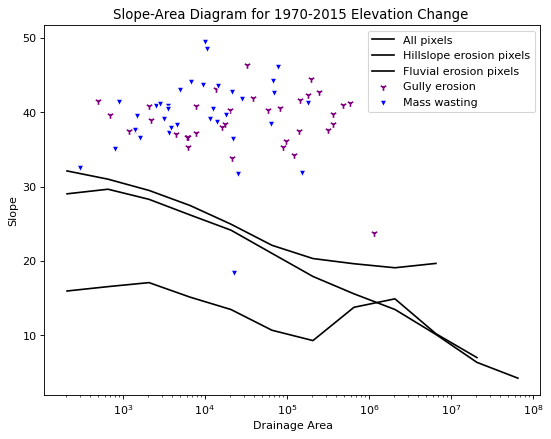

In [46]:
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(
    all_data_binned_df['drainage area'], 
    all_data_binned_df['slope'], 
    color='k', 
    # s=20, 
    # edgecolors= "white",
    label = 'All pixels'
)
plt.plot(
    hillslope_data_binned_df['drainage area'], 
    hillslope_data_binned_df['slope'], 
    color='k', 
    # s=20, 
    # edgecolors= "white",
    label = 'Hillslope erosion pixels'
)
plt.plot(
    fluvial_data_binned_df['drainage area'], 
    fluvial_data_binned_df['slope'], 
    color='k', 
    # s=20, 
    # edgecolors= "white",
    label = 'Fluvial erosion pixels'
)

plt.scatter(
    process_gdf.query("process == 'gully'")['drainage area'], 
    process_gdf.query("process == 'gully'")['slope'], 
    color='purple', 
    edgecolors= "white", 
    marker='1',
    label = "Gully erosion"
)
plt.scatter(
    process_gdf.query("process == 'mass wasting'")['drainage area'], 
    process_gdf.query("process == 'mass wasting'")['slope'], 
    color='blue', 
    edgecolors= "white", 
    marker='v',
    label = "Mass wasting"
)
plt.xscale('log')
plt.xlabel("Drainage Area")
plt.ylabel("Slope")
plt.title("Slope-Area Diagram for 1970-2015 Elevation Change ")
plt.legend()
plt.show()

In [47]:
src = process_gdf[process_gdf.process.isin(["gully", "mass wasting"])]
darea_plot = alt.Chart(src).mark_point().encode(
    alt.X('drainage area:Q', scale=alt.Scale(type='log')),
    alt.Y('ddem:Q'),
    alt.Color("process:N")
)
slope_plot = alt.Chart(src).mark_point().encode(
    alt.X('slope:Q', scale=alt.Scale(zero=False)),
    alt.Y('ddem:Q'),
    alt.Color("process:N")
)
curv_plot = alt.Chart(src).mark_point().encode(
    alt.X('curvature:Q', scale=alt.Scale(zero=False)),
    alt.Y('ddem:Q'),
    alt.Color("process:N")
)
(darea_plot) | (slope_plot) | curv_plot

alt.HConcatChart(...)

In [48]:
all_data_binned_df['type'] = 'All pixels'
hillslope_data_binned_df['type'] = 'Hillslope area'
fluvial_data_binned_df['type'] = 'Fluvial area'

binned_data = pd.concat([
    all_data_binned_df,
    hillslope_data_binned_df,
    fluvial_data_binned_df,
])

lines = alt.Chart(binned_data).mark_line().encode(
    alt.X("drainage area:Q", scale=alt.Scale(type='log'), title='Drainage area (square meters)'),
    alt.Y("slope:Q"),
    alt.Color(
        "type:N", 
        scale=alt.Scale(
            domain=['Fluvial area', 'Hillslope area', 'All pixels', 'glacial', 'not glacial'], 
            range=['#1f77b4', '#d62728', '#000000', '#17becf', '#2ca02c']
        )
    )
)

src = process_gdf[process_gdf.process.isin(["gully", "mass wasting", "glacial"])]
src.process = src.process.apply(lambda x: 'not glacial' if x in ['gully', 'mass wasting'] else 'glacial')

points = alt.Chart(src).mark_point().encode(
    alt.X("drainage area:Q", scale=alt.Scale(type='log', domain=[100, 10000000], clamp=True)),
    alt.Y("slope:Q", title = 'Slope (degrees)'),
    alt.Color("process:N"),
    shape = alt.Shape("process:N", scale=alt.Scale(range=['circle', 'triangle-right']))
)

lines_and_points_plot = (lines + points).configure_axis(grid=True)
lines_and_points_plot

/home/elilouis/mambaforge/envs/hsfm/lib/python3.9/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


alt.LayerChart(...)

/tmp/ipykernel_117868/1552094883.py:17: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  lgnd1.legendHandles[0]._sizes = [30]
/tmp/ipykernel_117868/1552094883.py:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  lgnd1.legendHandles[1]._sizes = [30]


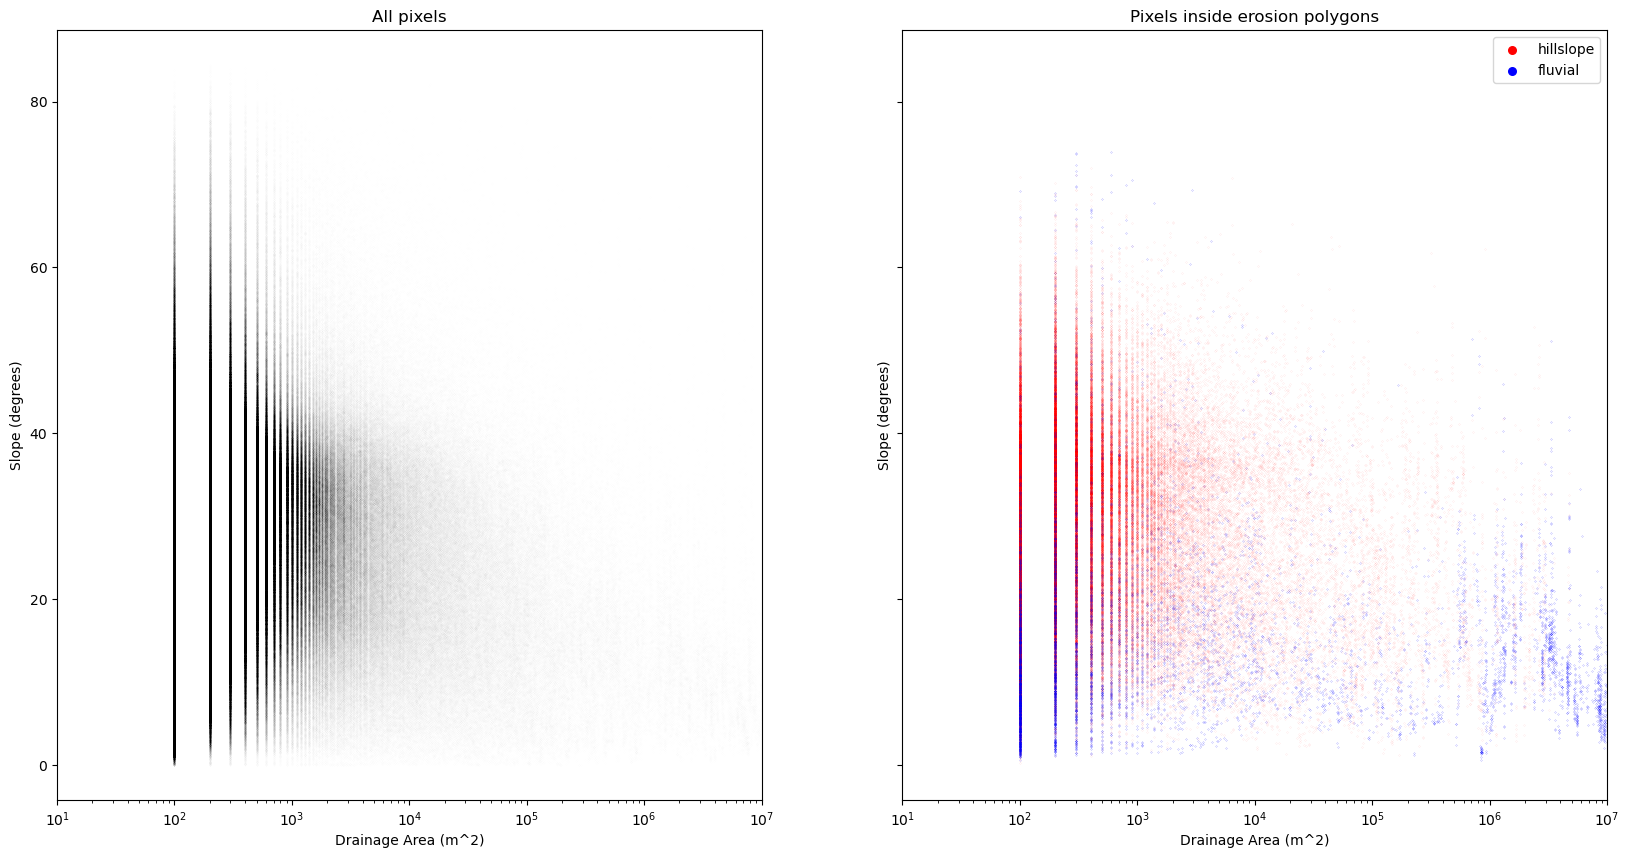

In [49]:
fig, axes = plt.subplots(1,2, figsize=(20,10), sharex=True, sharey=True)
axes[0].scatter(all_data_df['drainage area'], all_data_df['slope'], s=0.00001, color='k')
axes[1].scatter(hillslope_data_df['drainage area'], hillslope_data_df['slope'], s=0.001, color='red', label='hillslope')
axes[1].scatter(fluvial_data_df['drainage area'], fluvial_data_df['slope'], s=0.01, color='blue', label='fluvial')

for ax in axes:
    ax.set_xlim(10,10e6)
    # ax.set_ylim(0,60)
    ax.set_xscale('log')
    ax.set_xlabel("Drainage Area (m^2)")
    ax.set_ylabel("Slope (degrees)")

axes[0].set_title("All pixels")
axes[1].set_title("Pixels inside erosion polygons")
lgnd1 = axes[1].legend(loc="upper right")

lgnd1.legendHandles[0]._sizes = [30]
lgnd1.legendHandles[1]._sizes = [30]

plt.show()

In [50]:
src.process.unique()

array(['not glacial', 'glacial'], dtype=object)

/tmp/ipykernel_117868/3547647952.py:37: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  lgnd1.legendHandles[0]._sizes = [30]
/tmp/ipykernel_117868/3547647952.py:38: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  lgnd1.legendHandles[1]._sizes = [30]


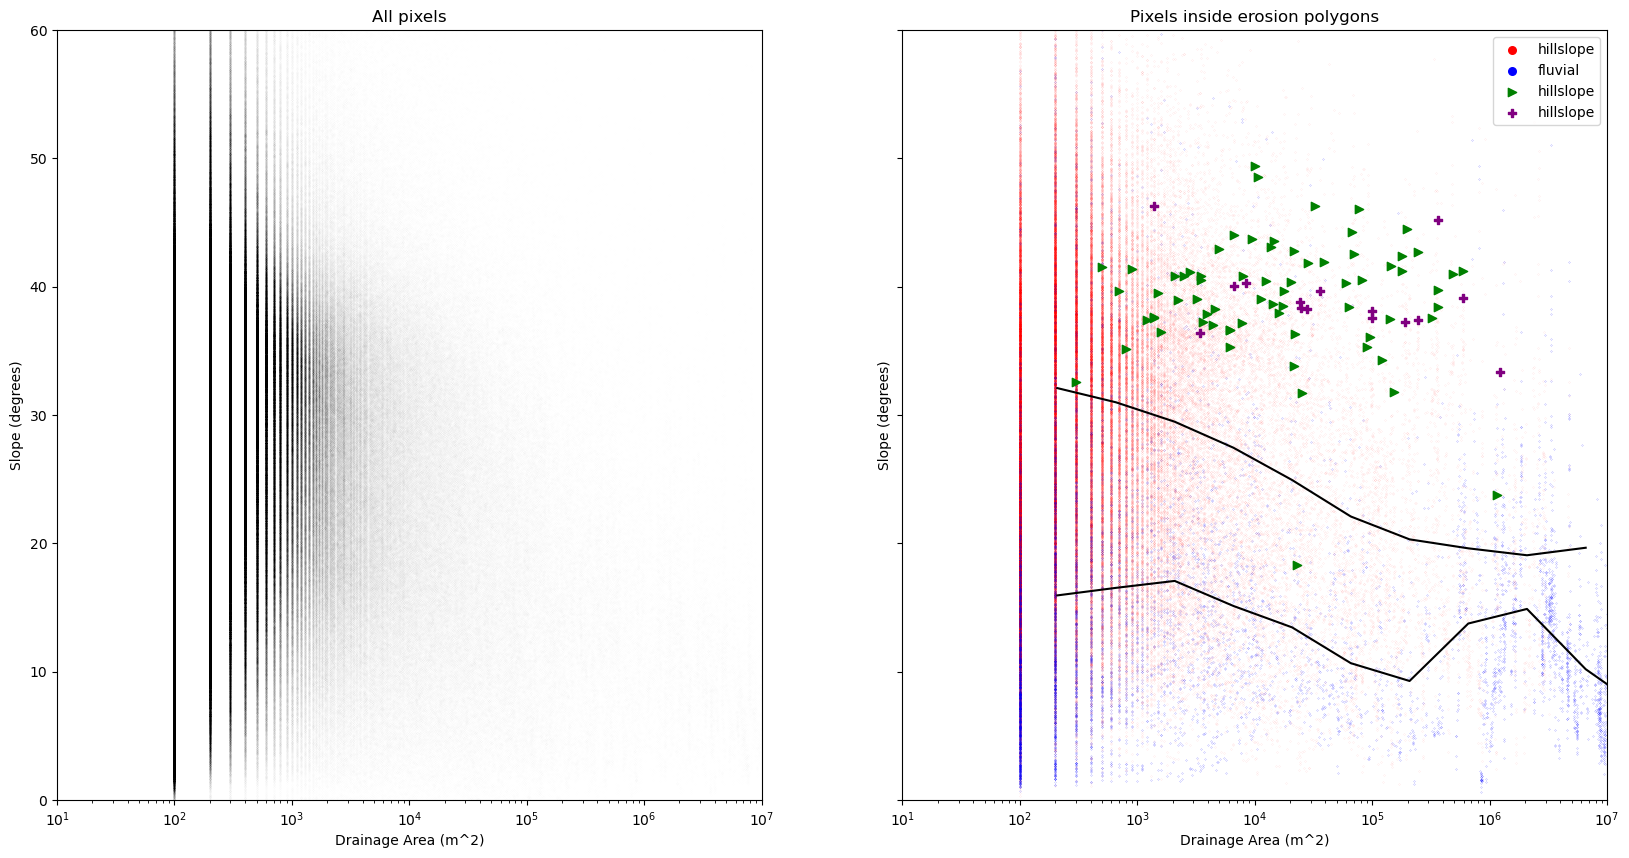

In [51]:
fig, axes = plt.subplots(1,2, figsize=(20,10), sharex=True, sharey=True)
axes[0].scatter(all_data_df['drainage area'], all_data_df['slope'], s=0.00001, color='k')
axes[1].scatter(hillslope_data_df['drainage area'], hillslope_data_df['slope'], s=0.001, color='red', label='hillslope')
axes[1].scatter(fluvial_data_df['drainage area'], fluvial_data_df['slope'], s=0.01, color='blue', label='fluvial')

axes[1].scatter(
    src.query('process == "not glacial"')['drainage area'], src.query('process == "not glacial"')['slope'], color='green', marker='>', label='hillslope'
)
axes[1].scatter(src.query('process == "glacial"')['drainage area'], src.query('process == "glacial"')['slope'], color='purple', marker='P', label='hillslope')

axes[1].plot(
    hillslope_data_binned_df['drainage area'], 
    hillslope_data_binned_df['slope'], 
    color='k', 
    # s=20, 
    # edgecolors= "white",
)
axes[1].plot(
    fluvial_data_binned_df['drainage area'], 
    fluvial_data_binned_df['slope'], 
    color='k', 
    # s=20, 
    # edgecolors= "white",
)

for ax in axes:
    ax.set_xlim(10,10e6)
    ax.set_ylim(0,60)
    ax.set_xscale('log')
    ax.set_xlabel("Drainage Area (m^2)")
    ax.set_ylabel("Slope (degrees)")

axes[0].set_title("All pixels")
axes[1].set_title("Pixels inside erosion polygons")
lgnd1 = axes[1].legend(loc="upper right")

lgnd1.legendHandles[0]._sizes = [30]
lgnd1.legendHandles[1]._sizes = [30]

plt.show()

/tmp/ipykernel_117868/2995033823.py:33: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  lgnd1.legendHandles[0]._sizes = [30]
/tmp/ipykernel_117868/2995033823.py:34: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  lgnd1.legendHandles[1]._sizes = [30]


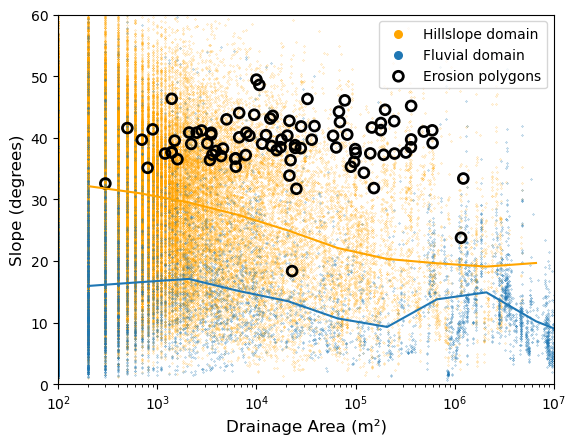

In [52]:

fig, ax = plt.subplots()
ax.scatter(hillslope_data_df['drainage area'], hillslope_data_df['slope'], s=0.025,  color='orange', label='Hillslope domain')
ax.scatter(fluvial_data_df['drainage area'], fluvial_data_df['slope'], s=0.05, color='#1f77b4', label='Fluvial domain')

points_src = src[src['process'].isin(['glacial', 'not glacial'])]
ax.scatter(points_src['drainage area'], points_src['slope'], facecolor='none', edgecolor='black', linewidth=2, marker='o', s=50, label='Erosion polygons')

ax.plot(
    hillslope_data_binned_df['drainage area'], 
    hillslope_data_binned_df['slope'], 
    color='orange', 
    # alpha=0.5,
    # s=20, 
    # edgecolors= "white",
)
ax.plot(
    fluvial_data_binned_df['drainage area'], 
    fluvial_data_binned_df['slope'], 
    color='#1f77b4', 
    # alpha=0.5,
    # s=20, 
    # edgecolors= "white",
)


ax.set_xlim(100,10e6)
ax.set_ylim(0,60)
ax.set_xscale('log')
ax.set_xlabel("Drainage Area (m²)", fontsize=12)
ax.set_ylabel("Slope (degrees)", fontsize=12)
lgnd1 = ax.legend(loc="upper right")

lgnd1.legendHandles[0]._sizes = [30]
lgnd1.legendHandles[1]._sizes = [30]
# plt.grid(True, which='both', alpha=0.5)
plt.gca().set_axisbelow(True)
plt.show()

In [55]:
src = pd.concat([
    hillslope_data_df,
    fluvial_data_df
]).dropna()

In [58]:
len(src.dropna()[src['slope'] > 34]) / len(src.dropna()['slope'])

0.3175257476728065

In [57]:
len(src.dropna()[src['slope'] > 19]) / len(src.dropna()['slope'])

0.7299341453753219

In [53]:
len(hillslope_data_df.dropna()[hillslope_data_df['slope'] > 34]) / len(hillslope_data_df.dropna()['slope'])

/tmp/ipykernel_117868/2026627427.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len(hillslope_data_df.dropna()[hillslope_data_df['slope'] > 34]) / len(hillslope_data_df.dropna()['slope'])


0.344769496260991

/tmp/ipykernel_117868/1227683495.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(hillslope_data_df['slope'], ax=axes[0], label='Hillslope Domain', color='orange')
/tmp/ipykernel_117868/1227683495.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(fluvial_data_df['slope'], ax=axes[1], label=

(0.0, 80.0)

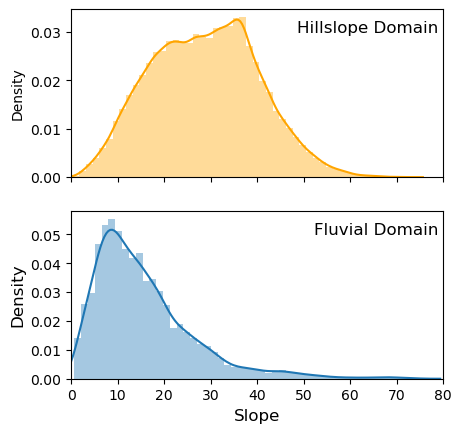

In [54]:
fig, axes = plt.subplots(2,1, sharex=True, figsize=(4.8, 4.8))
sns.distplot(hillslope_data_df['slope'], ax=axes[0], label='Hillslope Domain', color='orange')
axes[0].annotate("Hillslope Domain", xy=(79,0.03), horizontalalignment='right', fontsize=12)
sns.distplot(fluvial_data_df['slope'], ax=axes[1], label='Fluvial Domain')
axes[1].annotate("Fluvial Domain", xy=(79,0.05), horizontalalignment='right', fontsize=12)
plt.xlabel("Slope", fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.xlim(0,80)

In [53]:
len(points_src.query("slope > 34")), len(points_src.query("slope <= 34"))

(78, 7)

In [54]:
lia_outlet_intersections_gdf = gpd.read_file('/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/lia_outlet_intersections.shp')

In [55]:
lia_outlet_intersections_gdf

id   valley                                           geometry
0 NaN   Deming  POLYGON ((-121.88754 48.73641, -121.88717 48.7...
1 NaN   Easton  POLYGON ((-121.82870 48.71820, -121.82851 48.7...
2 NaN  Coleman  POLYGON ((-121.88860 48.81119, -121.88847 48.8...
3 NaN   Mazama  POLYGON ((-121.79048 48.83467, -121.78901 48.8...
4 NaN  Rainbow  POLYGON ((-121.73917 48.79153, -121.73929 48.7...

In [56]:
for row in lia_outlet_intersections_gdf.iterrows():
    print(row['valley'])
    print(dataset['drainage area'].rio.clip([row['geometry']]).max())
    print(dataset['slope'].rio.clip([row['geometry']]).max())

TypeError: tuple indices must be integers or slices, not str

In [ ]:
len(src[src['process'] == 'glacial']), len(src[src['process'] == 'not glacial'])

## Terrain characteristics of watersheds, considering all area within watershed

### Prep some DDEM raster datasets

#### Read in uncertainty parameters for thresholding

In [ ]:
uncertainty_df = pd.read_pickle(dod_uncertainty_fn)
uncertainty_df = uncertainty_df[uncertainty_df['Start Date'] == demcollection.ddems[0].start_time]
uncertainty_df = uncertainty_df[uncertainty_df['End Date'] == demcollection.ddems[0].end_time]
assert len(uncertainty_df) == 1
low = uncertainty_df['90% CI Lower Bound'].iloc[0]
hi = uncertainty_df['90% CI Upper Bound'].iloc[0]

#### Create new datasets: 

* ddem erosion (elevation changes in erosion areas only)
* ddem hillslope (elevation changes in hillslope erosion areas only)
* ddem fluvial (elevation changes in fluvial erosion areas only)
* ddem negative (negative elevation changes in all areas)
* ddem erosion negative (negative elevation changes in erosion areas only all areas)
* ddem hillslope negative (negative elevation changes in hillslope erosion areas only all areas)
* ddem fluvial negative (negative elevation changes in fluvial erosion areas only all areas)

In [ ]:
dataset

In [ ]:
dataset['ddem erosion'] = dataset['ddem'].rio.clip(erosion_gdf.geometry)
# dataset['ddem erosion'] = dataset['ddem erosion'].where(dataset['ddem erosion'] != dataset['ddem erosion'].attrs['_FillValue'])
dataset['ddem hillslope'] = dataset['ddem'].rio.clip(erosion_gdf.query("type == 'hillslope'").geometry)
# dataset['ddem hillslope'] = dataset['ddem hillslope'].where(dataset['ddem hillslope'] != dataset['ddem hillslope'].attrs['_FillValue'])
dataset['ddem fluvial'] = dataset['ddem'].rio.clip(erosion_gdf.query("type == 'fluvial'").geometry)
# dataset['ddem fluvial'] = dataset['ddem fluvial'].where(dataset['ddem fluvial'] != dataset['ddem fluvial'].attrs['_FillValue'])

dataset['ddem negative'] = xr.where(dataset['ddem'] < 0, dataset['ddem'], np.nan)
dataset['ddem negative'] = xr.where(
    np.logical_or(dataset['ddem negative'] < low, np.isnan(dataset['ddem negative'])), 
    dataset['ddem negative'], 
    0
)

dataset['ddem erosion negative'] = xr.where(dataset['ddem erosion'] < 0, dataset['ddem erosion'], np.nan)
dataset['ddem erosion negative'] = xr.where(
    np.logical_or(dataset['ddem erosion negative'] < low, np.isnan(dataset['ddem erosion negative'])), 
    dataset['ddem erosion negative'], 
    0
)

dataset['ddem hillslope negative'] = xr.where(dataset['ddem hillslope'] < 0, dataset['ddem hillslope'], np.nan)
dataset['ddem hillslope negative'] = xr.where(
    np.logical_or(dataset['ddem hillslope negative'] < low, np.isnan(dataset['ddem hillslope negative'])), 
    dataset['ddem hillslope negative'], 
    0
)

dataset['ddem fluvial negative'] = xr.where(dataset['ddem fluvial'] < 0, dataset['ddem fluvial'], np.nan)
dataset['ddem fluvial negative'] = xr.where(
    np.logical_or(dataset['ddem fluvial negative'] < low, np.isnan(dataset['ddem fluvial negative'])), 
    dataset['ddem fluvial negative'], 
    0
)

#### Plot new dataset variables

In [ ]:
fig, axes = plt.subplots(
    2, 
    len(dataset.data_vars)-6, 
    figsize=(6*(len(dataset.data_vars)-6), 6*2)
)

cmap = copy.copy(matplotlib.cm.RdYlBu)
_ = cmap.set_bad('grey')
from matplotlib import colors

for i, var in enumerate(list(dataset.data_vars)[6:]):
    if var == "drainage area":
        axes[0, i].imshow(dataset[var].values.squeeze(), norm=colors.LogNorm())
    else:
        dataset[var].plot(ax = axes[0, i], cmap=cmap)
    axes[0, i].set_title(str(var))
    axes[0, i].set_xticks([])
    axes[0, i].set_yticks([])
    sns.distplot(dataset[var].values, ax = axes[1, i])
plt.tight_layout()
plt.show()

### Open StreamStats watersheds


In [ ]:
gdf = gpd.GeoDataFrame()
for f in streamstats_watersheds_fns:
    new_data = gpd.read_file(f)
    new_data['Valley Name'] = f.split("/")[-1].split(".geojson")[0]
    gdf = gdf.append(new_data)

gdf = gdf.to_crs(dataset['ddem'].rio.crs)
nhd_df = gdf[gdf.geometry.type != "Point"]

In [ ]:
nhd_df.plot()

In [ ]:
for var in dataset.data_vars:
    values = dataset[var].values.copy()
    values[
        np.isnan(dataset.data_vars['ddem'].values)
    ] = np.nan
    dataset[var].values = values

### Calculate watershed statistics with watershed polygons

In [ ]:
mean_results = nhd_df.apply(
    (lambda row: dataset.rio.clip([row['geometry']]).to_dataframe().agg({
            'dtm': 'mean',
            'drainage area': 'max',
            'slope': 'mean',
            'aspect': 'mean',
            'curvature': 'mean',
            
            'ddem': 'sum',
            'ddem erosion': 'sum',
            'ddem hillslope': 'sum',
            'ddem fluvial': 'sum',
            'ddem negative': 'sum',
            'ddem erosion negative': 'sum',
            'ddem hillslope negative': 'sum',
            'ddem fluvial negative': 'sum',
            
        }
    )),
    axis='columns', result_type='expand'
)
nhd_df[mean_results.columns] = mean_results

### Calculate glacial area in start year, end year, max year (1979) and changes in that area

In [ ]:
glaciers_start = all_glaciers_gdf[all_glaciers_gdf.year == datetime.strftime(pd.to_datetime(demcollection.timestamps[0]), strip_time_format)]
glaciers_end = all_glaciers_gdf[all_glaciers_gdf.year == datetime.strftime(pd.to_datetime(demcollection.timestamps[-1]), strip_time_format)]
glaciers_max = all_glaciers_gdf.query("year == '1979_10_06'").append(
    all_glaciers_gdf.query("year == '1977_09_27' and Name == 'Rainbow Glacier WA'")
)

nhd_df['starting glacial area'] = nhd_df.geometry.apply(lambda watershed_geom: glaciers_start.geometry.apply(lambda geo: watershed_geom.intersection(geo)).area.sum())
nhd_df['ending glacial area'] = nhd_df.geometry.apply(lambda watershed_geom: glaciers_end.geometry.apply(lambda geo: watershed_geom.intersection(geo)).area.sum())
nhd_df['max glacial area'] = nhd_df.geometry.apply(lambda watershed_geom: glaciers_max.geometry.apply(lambda geo: watershed_geom.intersection(geo)).area.sum())
nhd_df['glacial advance area'] = nhd_df['max glacial area'] - nhd_df['starting glacial area']
nhd_df['glacial retreat area'] = nhd_df['ending glacial area'] - nhd_df['max glacial area']

In [ ]:
nhd_df[[
    'Valley Name',
    'starting glacial area',
    'max glacial area',
    'ending glacial area',
    'glacial advance area',
    'glacial retreat area'  
]]

In [ ]:
pixel_area = np.abs(dataset.rio.resolution()[0]*dataset.rio.resolution()[1])

In [ ]:
nhd_df['ddem'] = nhd_df['ddem']*pixel_area
nhd_df['ddem erosion'] = nhd_df['ddem erosion']*pixel_area
nhd_df['ddem hillslope'] = nhd_df['ddem hillslope']*pixel_area
nhd_df['ddem fluvial'] = nhd_df['ddem fluvial']*pixel_area
nhd_df['ddem negative'] = nhd_df['ddem negative']*pixel_area
nhd_df['ddem erosion negative'] = nhd_df['ddem erosion negative']*pixel_area
nhd_df['ddem hillslope negative'] = nhd_df['ddem hillslope negative']*pixel_area
nhd_df['ddem fluvial negative'] = nhd_df['ddem fluvial negative']*pixel_area

### Calculate erosion measurement area and incision rates

In [ ]:
# np.count_nonzero(~np.isnan(data))
nhd_df['area'] = nhd_df.apply(
    lambda row: np.count_nonzero(~np.isnan(dataset['ddem'].rio.clip([row['geometry']]).values))*pixel_area, axis='columns'
)
nhd_df['area erosion'] = nhd_df.apply(
    lambda row: np.count_nonzero(~np.isnan(dataset['ddem erosion'].rio.clip([row['geometry']]).values))*pixel_area, axis='columns'
)
nhd_df['area hillslope'] = nhd_df.apply(
    lambda row: np.count_nonzero(~np.isnan(dataset['ddem hillslope'].rio.clip([row['geometry']]).values))*pixel_area, axis='columns'
)
nhd_df['area fluvial'] = nhd_df.apply(
    lambda row: np.count_nonzero(~np.isnan(dataset['ddem fluvial'].rio.clip([row['geometry']]).values))*pixel_area, axis='columns'
)

In [ ]:
nhd_df['ddem incision'] = nhd_df['ddem'] / nhd_df['area']
nhd_df['ddem erosion incision'] = nhd_df['ddem erosion'] / nhd_df['area erosion']
nhd_df['ddem hillslope incision'] = nhd_df['ddem hillslope'] / nhd_df['area hillslope']
nhd_df['ddem fluvial incision'] = nhd_df['ddem fluvial'] / nhd_df['area fluvial']

nhd_df['ddem negative incision'] = nhd_df['ddem negative'] / nhd_df['area']
nhd_df['ddem erosion negative incision'] = nhd_df['ddem erosion negative'] / nhd_df['area erosion']
nhd_df['ddem hillslope negative incision'] = nhd_df['ddem hillslope negative'] / nhd_df['area hillslope']
nhd_df['ddem fluvial negative incision'] = nhd_df['ddem fluvial negative'] / nhd_df['area fluvial']

In [ ]:
nhd_df

### Plot: pair plots

In [ ]:
src = nhd_df[[
    'Valley Name',
    'dtm',
    'drainage area',
    'slope',
    'aspect',
    'curvature',
    'max glacial area',
    'glacial advance area',
    'glacial retreat area',
    'ddem',
    'ddem erosion',
    'ddem hillslope',
    'ddem fluvial',
]]


g = sns.PairGrid(src, hue ='Valley Name')
# g = g.map_diag(plt.hist, histtype="step", linewidth=3)
g = g.map_offdiag(plt.scatter)
g = g.add_legend()

In [ ]:
src = nhd_df[[
    'Valley Name',
    'dtm',
    'drainage area',
    'slope',
    'aspect',
    'curvature',
    'max glacial area',
    'glacial advance area',
    'glacial retreat area',
    'ddem incision',
    'ddem erosion incision',
    'ddem hillslope incision',
    'ddem fluvial incision',
]]

src = src[src["Valley Name"] != 'thunder']


g = sns.PairGrid(src, hue ='Valley Name')
# g = g.map_diag(plt.hist, histtype="step", linewidth=3)

g = g.map_offdiag(plt.scatter)
g = g.add_legend()

In [ ]:
src = nhd_df[[
    'Valley Name',
    'dtm',
    'drainage area',
    'slope',
    'aspect',
    'curvature',
    'max glacial area',
    'glacial advance area',
    'glacial retreat area',
    'ddem negative',
    'ddem erosion negative',
    'ddem hillslope negative',
    'ddem fluvial negative',
]]


g = sns.PairGrid(src, hue ='Valley Name')
# g = g.map_diag(plt.hist, histtype="step", linewidth=3)
g = g.map_offdiag(plt.scatter)
g = g.add_legend()

In [ ]:
plt.scatter(src['drainage area'], src['slope'], c=src['ddem erosion negative incision'])
plt.xlabel("Maximum drainage value of pixels in watershed")
plt.ylabel("Mean slope value of pixels in watershed")
plt.colorbar(label='Gross negative elevation change')
for idx, row in src.iterrows():
    if row['Valley Name'] == 'coleman':
        plt.annotate(row['Valley Name'], (row['drainage area'] - 22000, row['slope']) )
    else:
        plt.annotate(row['Valley Name'], (row['drainage area'] + 2000, row['slope']) )
plt.show()

In [ ]:
chart = alt.Chart(src).mark_circle(size=100).encode(
    alt.X('drainage area:Q', scale=alt.Scale(zero=False), title='Drainage Area at Watershed Outlet'),
    alt.Y('slope:Q', scale=alt.Scale(zero=False), title='Watershed Mean Slope'),
    alt.Color('ddem erosion negative incision:Q', scale=alt.Scale(scheme='viridis'))
)
annotations1 = alt.Chart(src).mark_text(
    align='right',
    baseline='middle',
    fontSize = 14,
    dx = -7
).transform_filter(
    alt.FieldRangePredicate(field='drainage area', range=[100000, 10000000])
).encode(
    alt.X('drainage area:Q', scale=alt.Scale(zero=False)),
    alt.Y('slope:Q', scale=alt.Scale(zero=False)),
    text='Valley Name'
)

annotations2 = alt.Chart(src).mark_text(
    align='left',
    baseline='middle',
    fontSize = 14,
    dx = 7
).transform_filter(
    alt.FieldRangePredicate(field='drainage area', range=[0, 100000])
).encode(
    alt.X('drainage area:Q', scale=alt.Scale(zero=False)),
    alt.Y('slope:Q', scale=alt.Scale(zero=False)),
    text='Valley Name'
)

(chart + annotations1 + annotations2).configure_axis(grid=False)

## Terrain characteristics of watersheds, hillslope + fluvial erosion area only

### Calculate watershed statistics within erosion polygons only

In [ ]:
limited_erosion_gdf = erosion_gdf.dissolve(by='name')

limited_erosion_bytype_gdf = erosion_gdf.dissolve(by=['name', 'type'])

In [ ]:
erosion_mean_results = limited_erosion_gdf.apply(
    (lambda row: dataset.rio.clip([row['geometry']]).to_dataframe().agg({
            'dtm': 'mean',
            'drainage area': 'max',
            'slope': 'mean',
            'aspect': 'mean',
            'curvature': 'mean',
            
            'ddem': 'sum',
            'ddem erosion': 'sum',
            'ddem hillslope': 'sum',
            'ddem fluvial': 'sum',
            'ddem negative': 'sum',
            'ddem erosion negative': 'sum',
            'ddem hillslope negative': 'sum',
            'ddem fluvial negative': 'sum',
            
        }
    )),
    axis='columns', result_type='expand'
)
limited_erosion_gdf[erosion_mean_results.columns] = erosion_mean_results

In [ ]:
erosion_mean_results_bytype = limited_erosion_bytype_gdf.apply(
    (lambda row: dataset.rio.clip([row['geometry']]).to_dataframe().agg({
            'dtm': 'mean',
            'drainage area': 'max',
            'slope': 'mean',
            'aspect': 'mean',
            'curvature': 'mean',
            
            'ddem': 'sum',
            'ddem erosion': 'sum',
            'ddem hillslope': 'sum',
            'ddem fluvial': 'sum',
            'ddem negative': 'sum',
            'ddem erosion negative': 'sum',
            'ddem hillslope negative': 'sum',
            'ddem fluvial negative': 'sum',
            
        }
    )),
    axis='columns', result_type='expand'
)
limited_erosion_bytype_gdf[erosion_mean_results_bytype.columns] = erosion_mean_results_bytype

In [ ]:
src = limited_erosion_gdf.drop(columns=['geometry']).reset_index()

# src = src[src.name.isin(['Easton', 'Rainbow', 'Coleman', 'Deming', 'Mazama'])]

chart = alt.Chart(src).mark_circle(size=100).encode(
    alt.X('drainage area:Q', scale=alt.Scale(zero=False), title='Drainage Area at Watershed Outlet'),
    alt.Y('slope:Q', scale=alt.Scale(zero=False), title='Mean Slope in Erosion Measurement Area'),
    # alt.Color('ddem erosion negative:Q', scale=alt.Scale(scheme='viridis'))
)
annotations1 = alt.Chart(src).mark_text(
    align='right',
    baseline='middle',
    fontSize = 10,
    dx = -7
).encode(
    alt.X('drainage area:Q', scale=alt.Scale(zero=False)),
    alt.Y('slope:Q', scale=alt.Scale(zero=False)),
    text='name'
)

(chart + annotations1).configure_axis(grid=False)

In [ ]:
src = limited_erosion_bytype_gdf.drop(columns=['geometry']).reset_index()

src = src.query("type == 'fluvial'")

# src = src[src.name.isin(['Easton', 'Rainbow', 'Coleman', 'Deming', 'Mazama'])]

chart = alt.Chart(src).mark_circle(size=100).encode(
    alt.X('drainage area:Q', scale=alt.Scale(zero=False), title='Drainage Area at Watershed Outlet'),
    alt.Y('slope:Q', scale=alt.Scale(zero=False), title='Mean Slope in Erosion Measurement Area'),
    # alt.Color('ddem erosion negative:Q', scale=alt.Scale(scheme='viridis'))
)
annotations1 = alt.Chart(src).mark_text(
    align='right',
    baseline='middle',
    fontSize = 10,
    dx = -7
).encode(
    alt.X('drainage area:Q', scale=alt.Scale(zero=False)),
    alt.Y('slope:Q', scale=alt.Scale(zero=False)),
    text='name'
)

(chart + annotations1).configure_axis(grid=False)

In [ ]:
src = limited_erosion_bytype_gdf.drop(columns=['geometry']).reset_index()

src = src.query("type == 'hillslope'")

# src = src[src.name.isin(['Easton', 'Rainbow', 'Coleman', 'Deming', 'Mazama'])]

chart = alt.Chart(src).mark_circle(size=100).encode(
    alt.X('drainage area:Q', scale=alt.Scale(zero=False), title='Drainage Area at Watershed Outlet'),
    alt.Y('slope:Q', scale=alt.Scale(zero=False), title='Mean Slope in Erosion Measurement Area'),
    # alt.Color('ddem erosion negative:Q', scale=alt.Scale(scheme='viridis'))
)
annotations1 = alt.Chart(src).mark_text(
    align='right',
    baseline='middle',
    fontSize = 10,
    dx = -7
).encode(
    alt.X('drainage area:Q', scale=alt.Scale(zero=False)),
    alt.Y('slope:Q', scale=alt.Scale(zero=False)),
    text='name'
)

(chart + annotations1).configure_axis(grid=False)

In [ ]:
limited_erosion_gdf.reset_index().to_csv("outputs/terrain_attributes_erosionarea.csv", index=False)

limited_erosion_bytype_gdf.reset_index().to_csv("outputs/terrain_attributes_erosionarea_bytype.csv", index=False)

nhd_df.reset_index().to_csv("outputs/terrain_attributes_watershedarea.csv")


process_gdf.reset_index(drop=True).drop(columns='id').to_csv("outputs/terrain_attributes_processpolygons.csv")

In [ ]:
process_gdf

In [ ]:

process_gdf.reset_index(drop=True).drop(columns='id').to_csv("outputs/terrain_attributes_processpolygons_maxdrainage.csv")